In [67]:
import numpy as np

def score (x,y, blossom_matrix, amino_acids):

    m=len(x)
    n=len(y)

    sm= np.zeros((n+1,m+1))


    for i in range(n+1):
        sm[i][0]=max(0,-8*i)
    for i in range(m+1):
        sm[0][i]=max(0,-8*i)

    for i in range(1,n+1):
        for j in range(1,m+1):
            bb=blossom_matrix[amino_acids.index(y[i-1])][amino_acids.index(x[j-1])]
            sm[i][j]=max(0,sm[i-1][j]-8,sm[i][j-1]-8,sm[i-1][j-1]+bb )
    return max(map(max, sm))



In [ ]:
from numba import njit

@njit
def score_numba(x, y, blosum_matrix, aa_index):
    m = len(x)
    n = len(y)
    sm = np.zeros((n+1, m+1))

    for i in range(n+1):
        sm[i, 0] = max(0, -8*i)
    for j in range(m+1):
        sm[0, j] = max(0, -8*j)

    for i in range(1, n+1):
        yi = aa_index[y[i-1]]
        for j in range(1, m+1):
            xj = aa_index[x[j-1]]
            bb = blosum_matrix[yi, xj]
            sm[i, j] = max(0, sm[i-1, j] - 8, sm[i, j-1] - 8, sm[i-1, j-1] + bb)

    return np.max(sm)



In [20]:
testna = "FVFGDSLSDA"
proteins_file = "zad4_AT.fasta"
blosum_file = "zad3_blosum50.txt"
acids_file = "zad3_acids.txt"
ids = []
kiseline = []
scores = []

In [11]:
f1=open(acids_file, "r")
amino_acids=f1.readline()
f1.close()

blosum_matrix=[]
f1=open(blosum_file, "r")
for i in range(20):
    line=f1.readline()
    vc=line.split()
    blosum_matrix.append(vc[:])
for i in range(20):
    for j in range(20):
        blosum_matrix[i][j]=int(blosum_matrix[i][j])
f1.close()

In [21]:
from Bio import SeqIO



for record in SeqIO.parse(proteins_file, "fasta"):
    ids.append(record.id)
    kiseline.append(record.seq)
    scores.append(score(testna,record.seq,blosum_matrix,amino_acids))

In [53]:
names = []

with open("zad4_AT_imena.txt", "r") as f:
    for line in f:
        line = line.strip()
        if line.startswith(">"):
            # Ukloni znak '>' i podijeli po '|'
            parts = line[1:].split('|')
            
            names.append(parts[0][:-3])


In [55]:
truth = []

with open("zad4_ATBioPositives.txt", "r") as f:
    for line in f:
        line = line.strip()
        truth.append(line)


In [37]:
0.001 * len(scores)

33.410000000000004

In [84]:
scores_sorted= scores.copy()
scores_sorted.sort(reverse=True)
scores_sorted = np.array(scores_sorted)

sorted_indices = [i for i, _ in sorted(enumerate(scores), key=lambda x: x[1], reverse=True)]
pozitives = [names[i] for i in sorted_indices[:200]]

In [85]:
unik = np.unique(np.array(scores))[::-1]
granice = [np.sum(scores_sorted >= i) for i in unik]


104


In [103]:
tprs = []
fprs = []
for granica in granice[17:20]:
    positives  = list(set([names[i] for i in sorted_indices[:granica]]))

    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for name in positives:
        if name in truth:
            tp += 1
        else:
            fp +=1

    ukupno = len(scores)
    pozitivnih = len(truth)
    negativnih = ukupno - pozitivnih # = fp + tn
    tn = negativnih - fp
    fn = pozitivnih - tp  

    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    #precision = tpr/(tpr+fpr)
    #f1 = 2* (precision * tpr)/(precision + tpr)

    print(tpr, fpr, len(positives))
    tprs.append(tpr)
    fprs.append(fpr)

0.7211538461538461 0.00117096018735363 114
0.7980769230769231 0.0014712063892391761 132
0.8461538461538461 0.0021317480333873776 159


In [101]:
print(tprs[19])

0.8461538461538461


AUC = 0.7995897020171926


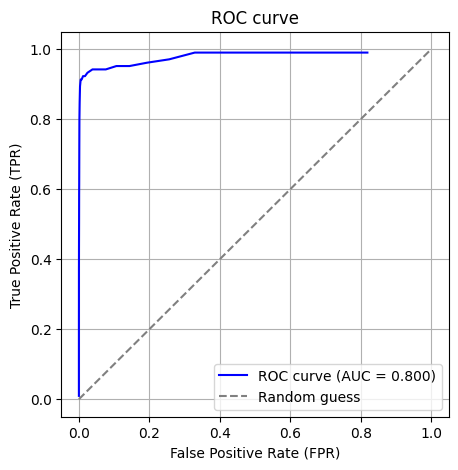

In [97]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc


# izračun AUC (numerička integracija)
roc_auc = auc(fprs, tprs)
print("AUC =", roc_auc)

# plot
plt.figure(figsize=(5,5))
plt.plot(fprs, tprs, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()